# `rioxarray`

`rioxarray`:

- is a Pythone extension for `xarray` to manipulate `xarray.DataArray` s as rasters
- means *Raster input/output + xarray *

## Data

Raster files from the US national ag imagery program (NAIP)

- high resolution aerial images from 2020 with four spectral bands: Red, Green, Blue, and Near infrared ( NIR)



In [35]:
import os
import numpy as np
import matplotlib.pyplot as plt

import rioxarray as rioxr

import geopandas as gpd
import xarray as xr
from shapely.geometry import Polygon

In [2]:
## import .tif

Use `rioxarray.open_rasterio()` function to open tif file

In [3]:
#load NIR tif file

#create file path

nir_fp = os.path.join(os.getcwd(), 'raster_data','nir.tif')

nir = rioxr.open_rasterio(nir_fp)
nir

<xarray.DataArray (band: 1, y: 3208, x: 2419)>
[7760152 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

## xr.dataarray exploration

In [4]:
type(nir)

xarray.core.dataarray.DataArray

In [5]:
#access some attributes

print('shape:', nir.shape)
print('data type:', nir.dtype)

shape: (1, 3208, 2419)
data type: uint8


In [6]:
#check value sof array at the corners

print(type(nir.values))
nir.values

<class 'numpy.ndarray'>


array([[[167, 164, 161, ..., 147, 152, 151],
        [170, 170, 168, ..., 151, 149, 154],
        [176, 177, 177, ..., 151, 151, 151],
        ...,
        [ 94,  88, 101, ...,  83,  88,  79],
        [108,  95, 103, ...,  92,  91,  75],
        [ 94,  90, 104, ...,  87,  88,  82]]], dtype=uint8)

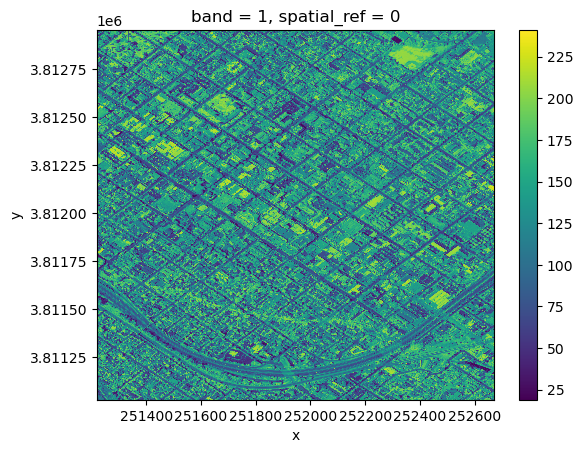

In [7]:
#exploratory plot

nir.plot()

An **accessor** in python lets us accesss a different set of properties from an object

Use the `.rio` accesor for `xarray.DatArray` to access its raster properties

**Example:**

In [8]:
print('# of bands:', nir.rio.count)
print('height:', nir.rio.height)
print('width', nir.rio.width)
print('resolution:', nir.rio.resolution())
print('no data values:', nir.rio.nodata, '\n')

print('spatial bounding box:')
print(nir.rio.bounds(), '\n')

print('CRS:', nir.rio.crs)



# of bands: 1
height: 3208
width 2419
resolution: (0.6000000000000072, -0.600000000000058)
no data values: None 

spatial bounding box:
(251218.8, 3811027.2, 252670.19999999998, 3812952.0) 

CRS: EPSG:26911


In [9]:
nir.rio.crs.is_projected

True

## Multi Band raster

# open RGB raster


In [10]:
rgb_fp = os.path.join(os.getcwd(),'raster_data', 'rgb.tif')
rgb =rioxr.open_rasterio(rgb_fp)
rgb

<xarray.DataArray (band: 3, y: 3208, x: 2419)>
[23280456 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [11]:
# check some number bands and shape
print('rgb shape:', rgb.shape)
print('rgb # of bands:', rgb.rio.shape)

rgb shape: (3, 3208, 2419)
rgb # of bands: (3208, 2419)


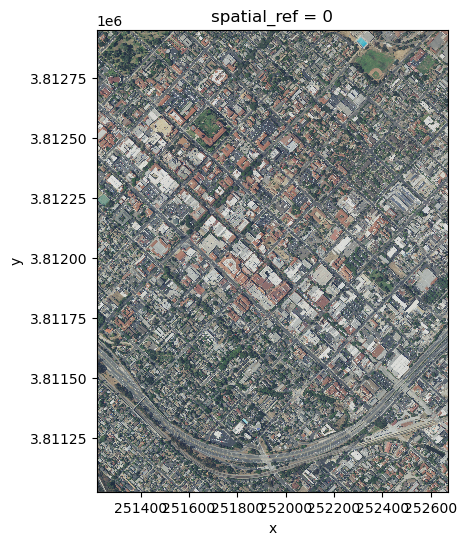

In [12]:
#parameters for plotting this raster

size = 6 # height of figure in inches
aspect = rgb.rio.width/rgb.rio.height # ratio width divided by heigh to make proportional

#plot three bands as RGB image

rgb.plot.imshow(size = size, aspect = aspect) # this is santa barbara

## Box for clipping 

our area of interest (aoi) is a smaller region with only a few blocks around NCEAS

In [13]:
#list of verticies of our aoi box
# got points from https://geojson.io/#map=2/0/20, made box around area of interest
points = [[ -119.70380682456592,34.42341863005292],
 [-119.70380682456592,34.421141414613956],
[-119.69988616149234, 34.421141414613956],
[-119.69988616149234,34.42341863005292],
[ -119.70380682456592,34.42341863005292]]
  

In [14]:
#create a geodataframe with aoi

aoi = gpd.GeoDataFrame(geometry = [Polygon(points)], 
                    crs = 'epsg:4326')

In [15]:
aoi.plot

# Clip raster 
remember : **if two geospatial sets will interact they need to be in the same CRS**

Check: 

In [16]:
print('aoi crs :', aoi.crs)
print('nir crs:', nir.rio.crs)
print('rgb Crs:', rgb.rio.crs)

aoi crs : epsg:4326
nir crs: EPSG:26911
rgb Crs: EPSG:26911


In [17]:
# reproject aoi to rgb crs
aoi = aoi.to_crs(rgb.rio.crs)
print('matched crs?', aoi.crs == rgb.rio.crs)
aoi.crs

matched crs? True


<Bound CRS: PROJCS["NAD83 / UTM zone 11N",GEOGCS["NAD83",DATUM ...>
Name: NAD83 / UTM zone 11N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: Transformation from NAD83 to WGS84
- method: Position Vector transformation (geog2D domain)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich
Source CRS: NAD83 / UTM zone 11N

<AxesSubplot:title={'center':'spatial_ref = 0'}, xlabel='x', ylabel='y'>

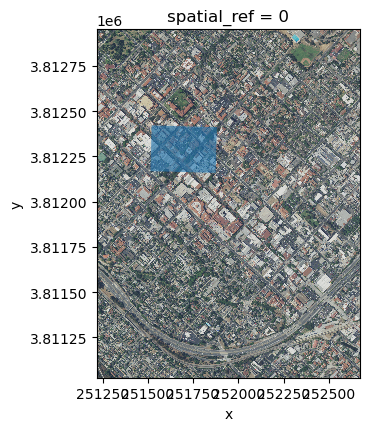

In [18]:
#plot aoi outline and RGb raster together 

fig, ax = plt.subplots()
fig.set_size_inches(size, size * aspect) # cannot use ax and size, aspect toggether
rgb.plot.imshow(ax = ax)
aoi.plot(ax = ax, alpha = 0.6)

To clip the raster using the aoi polygon we use the `.rio.clip_box()` method:

In [19]:
#clip rasters to aoi
rgb_small = rgb.rio.clip_box(*aoi.total_bounds)  # aoi.total bounds is min x, max, min y, max y of box
nir_small = nir.rio.clip_box(*aoi.total_bounds)

In [20]:
print('original shape:', rgb.shape)
print('reduced shape:', rgb_small.shape)

original shape: (3, 3208, 2419)
reduced shape: (3, 438, 613)


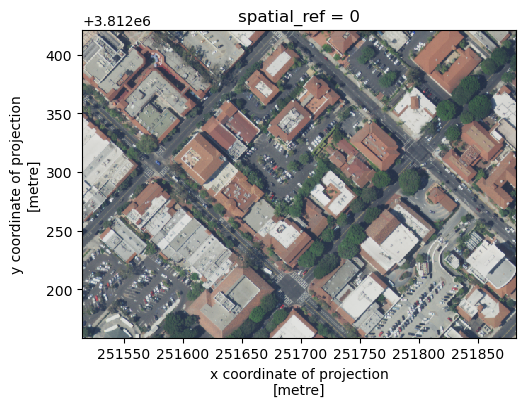

In [21]:
# plot it with correct ratio

size = 4 #height in inches
aspect =  rgb_small.rio.width / rgb_small.rio.height #ratio of width of height 
rgb_small.plot.imshow(size = size, aspect = aspect)

## Compute NDVI
NDVI = normalized difference vegetation index
We want to compute it over our aoi. 

NDVI: 
- index used to check if an area has live green vegetation
- calculated using only the red and NIR bands
- formula: $$NDVI = (NIR- Red)(NIR + Red)$$
- results: range from -1 to 1
- plants: always postiive values between 0.2 and 1

First, select the red band: 

In [22]:
red = rgb_small.sel(band = 1)
red

<xarray.DataArray (y: 438, x: 613)>
[268494 values with dtype=uint8]
Coordinates:
    band         int64 1
  * x            (x) float64 2.515e+05 2.515e+05 ... 2.519e+05 2.519e+05
  * y            (y) float64 3.812e+06 3.812e+06 ... 3.812e+06 3.812e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [23]:
nir_small

<xarray.DataArray (band: 1, y: 438, x: 613)>
array([[[185, 180, ..., 136, 139],
        [163, 160, ..., 128, 138],
        ...,
        [189, 160, ..., 157, 164],
        [206, 189, ..., 144, 150]]], dtype=uint8)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.515e+05 2.515e+05 ... 2.519e+05 2.519e+05
  * y            (y) float64 3.812e+06 3.812e+06 ... 3.812e+06 3.812e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

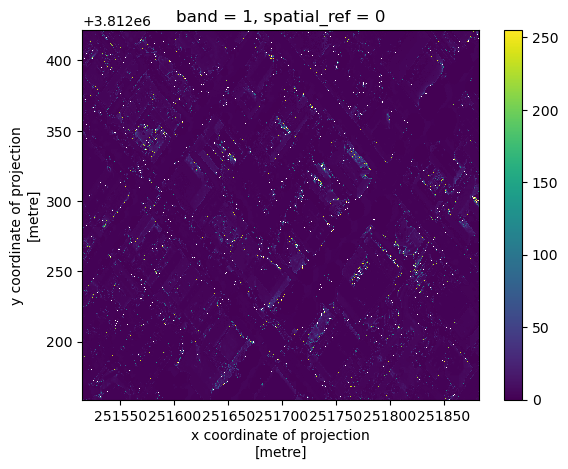

In [24]:
ndvi = (nir_small - red)/ (nir_small + red)
ndvi.plot()

## What is happening? 

Both NIR and red have `uint8` dtype. 
`uint8` (8 bit unsigned integer)
Very small data type that only holds integeres from 0 up to 255.

Calculations with `uint8` dont return what we are used to when working with integers. 

In [26]:
np.uint8(150)+np.uint8(150)

/tmp/ipykernel_1502141/3862072743.py:1: RuntimeWarning: overflow encountered in ubyte_scalars
  np.uint8(150)+np.uint8(150)


44

In NDVI forumla, we add NIR + Red. If both NIR and Red are very close to 255, when we add them, the calculation overflows the `uint8` dtype. 

Notice: when we performed the NDVI calculation, we did not get any warning.

This could be an example of *failing silently*.


**Important: check our results!**

Solution: update dtype of rasters to `int16` which will be big enough to perform the calculation. 


In [28]:
red16 = red.astype('int16')
nir16 = nir_small.astype('int16')
print('RED: original dtype', rgb_small.dtype,'... new dtype:', red16.dtype)
print('NIR: original dtype', nir_small.dtype,'... new dtype:', nir16.dtype)

RED: original dtype uint8 ... new dtype: int16
NIR: original dtype uint8 ... new dtype: int16


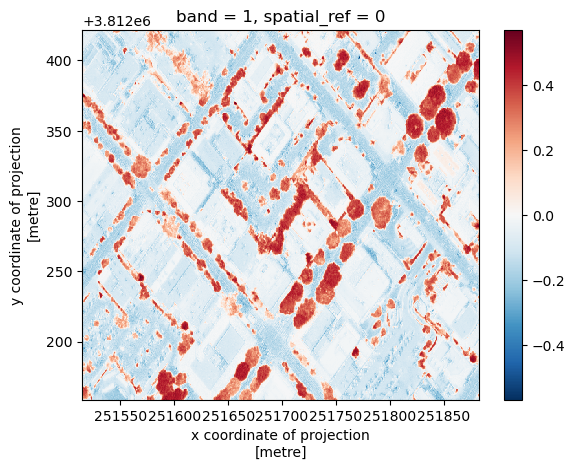

In [29]:
#perform raster calculations using the same arithmetic as np.arrays
ndvi = (nir16- red16)/ (nir16 + red16)
ndvi.plot()

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00, 9.0000e+00,
        1.5000e+01, 6.9000e+01, 2.2000e+02, 5.6000e+02, 1.4090e+03,
        3.3920e+03, 8.0890e+03, 1.4941e+04, 1.8770e+04, 2.0169e+04,
        2.8849e+04, 2.5022e+04, 2.6161e+04, 3.6018e+04, 2.2062e+04,
        5.6130e+03, 4.0740e+03, 2.8450e+03, 2.5200e+03, 2.4820e+03,
        2.4050e+03, 2.4210e+03, 2.4490e+03, 2.5340e+03, 2.7900e+03,
        2.9610e+03, 3.1660e+03, 3.3110e+03, 3.4510e+03, 3.4770e+03,
        3.5400e+03, 3.5110e+03, 3.2320e+03, 2.6320e+03, 1.9030e+03,
        9.7100e+02, 3.2900e+02, 9.0000e+01, 1.6000e+01, 4.0000e+00]),
 array([-0.55752212, -0.53498957, -0.51245701, -0.48992445, -0.4673919 ,
        -0.44485934, -0.42232679, -0.39979423, -0.37726167, -0.35472912,
        -0.33219656, -0.309664  , -0.28713145, -0.26459889, -0.24206634,
        -0.21953378, -0.19700122, -0.17446867, -0.15193611, -0.12940355,
        -0.106871  , -0.08

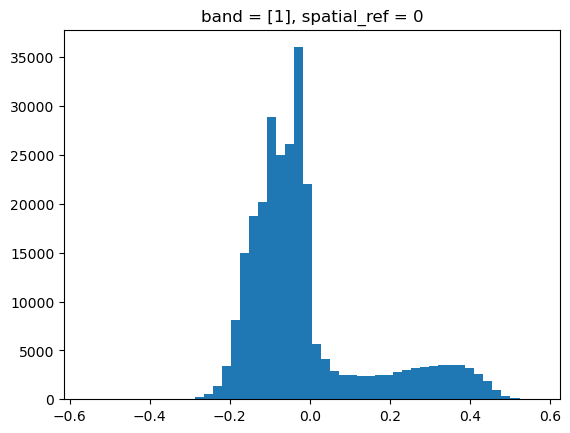

In [30]:
#create a histogram of ndvi values
ndvi.plot.hist(bins = 50)

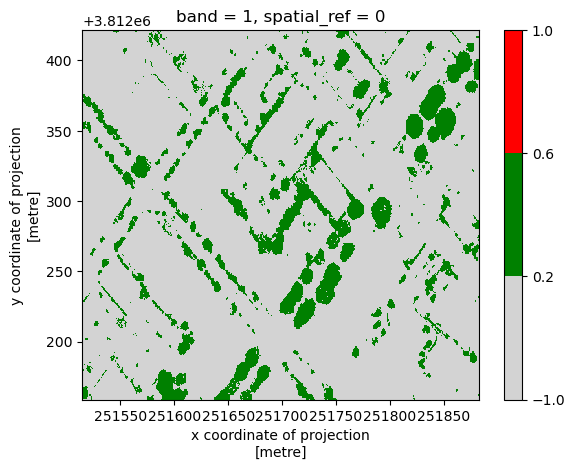

In [34]:
# - 1< NDVI < 0.2 : no vegetation
# 0.2 <= NDVI < 0.6 for sparse vegetation
# 0.6 <= NDVI < 1 for dense vegetation

class_bins = (-1, 0.2, 0.6, 1)
colors = ('lightgray','green', 'red')
ndvi.plot(levels = class_bins, colors = colors)

In [38]:
ndvi_classes = xr.apply_ufunc( # stores ndvi data in a new xarray
    np.digitize, 
    ndvi,
    class_bins)

ndvi_classes

<xarray.DataArray (band: 1, y: 438, x: 613)>
array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 2, 2, ..., 1, 1, 1],
        [1, 1, 2, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]]])
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.515e+05 2.515e+05 ... 2.519e+05 2.519e+05
  * y            (y) float64 3.812e+06 3.812e+06 ... 3.812e+06 3.812e+06
    spatial_ref  int64 0

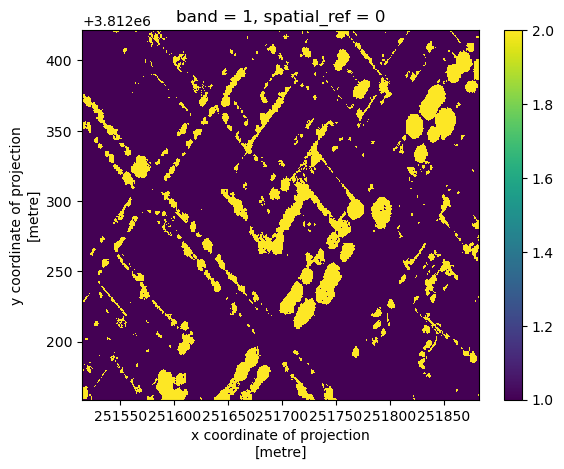

In [39]:
ndvi_classes.plot()